In [24]:
# google colab configurations 
# these might change
DATA_GENERATION = '13kwW8C01etWsqTYoE2eeFlD4Ft9YVhrw'
DATA_GENERATION_FILE = 'datageneration.py'

HELPERS = '1zskLM0-ZtEQYVI7zvd2ePqtkTOkJmVIL'
HELPERS_FILE = 'helpers.py'

EXPERIMENT = '1OrYHcTvUXHOrg-86_6oWaN2muDpuzn9a'
EXPERIMENT_FILE = 'experiment.py'


NETWORK = '1iFbCIY8IMaqO4I8mu2J7ie7UDJsLGtRv'
NETWORK_FILE = 'networks.py'

CONFIG = '14OF6o1luI8u10Nq96FLBP1M1k-VvQKq-'
CONFIG_FILE ='config.json'


google_colab = input('Running on Colab?\n')
if google_colab=='yes' : 
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    datageneration = drive.CreateFile({'id':DATA_GENERATION})
    datageneration.GetContentFile(DATA_GENERATION_FILE)
    

    helpers = drive.CreateFile({'id':HELPERS})
    helpers.GetContentFile(HELPERS_FILE)

    experiment = drive.CreateFile({'id':EXPERIMENT})
    experiment.GetContentFile(EXPERIMENT_FILE)

    json = drive.CreateFile({'id':CONFIG})
    json.GetContentFile(CONFIG_FILE)


Running on Colab?
yes


In [0]:
# custom imports
from experiment import Experiment
from datageneration import DataGenerator
from helpers import Helper
# torch imports
from torch.utils import data
import torch

# import utils
import json
from datetime import date

BASE_DIR = 'checkpoints'

with open('config.json') as f:
    file = f.read()
    conf = json.loads(file)

In [26]:
# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU')

Training on GPU!


## Generating a dataset

In [0]:
datagenerator = DataGenerator(**conf['default']['data_gen_params'])
x_values, func_x = datagenerator.generate_curves()
func_x = Helper.list_np_to_sensor(func_x)
x_values = x_values.repeat(func_x.shape[0], 1, 1)

In [0]:
train_len = int(x_values.shape[0] * conf['default']['train_share'])
traindata = data.TensorDataset(x_values[:train_len], func_x[:train_len])
trainloader = data.DataLoader(traindata, batch_size=100)
validata = data.TensorDataset(x_values[train_len:], func_x[train_len:])
valiloader = data.DataLoader(validata, batch_size=10)

In [0]:
experiment = Experiment(**conf['default']['experiment_params'])

Mean loss at epoch 20000 : 0.8813135623931885
 Validation loss after 20000 equals 0.9782840013504028


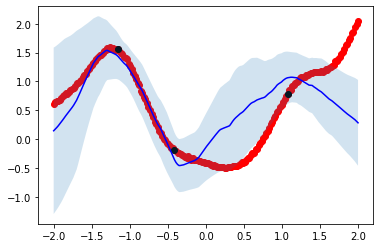

Mean loss at epoch 40000 : 0.5936150550842285
 Validation loss after 40000 equals 1.1998040676116943


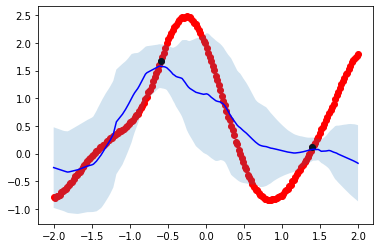

Mean loss at epoch 60000 : 0.8236392140388489
 Validation loss after 60000 equals 1.3652936220169067


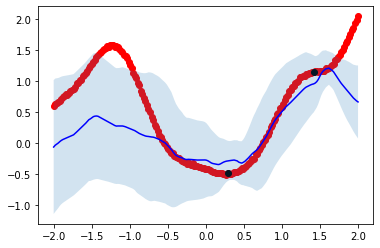

In [0]:
weights = experiment.run_training(trainloader,valiloader, plotting=True)

 ## Sandbox - testing the individual parts of the function

### Kernel function
Expanding the dimesions of the tensors allows us substract each point pairwise
This being a 1-D use case we simply substract each of the data points and get an n by n matrix for each layer.

In [0]:
batch_size = 64
num_points = 10
dimx = 1
dimy = 1
rdim = 20
hdim = 20
x = Helper.scale_shift_uniform(-2,2,batch_size,num_points,dimx)
y = Helper.scale_shift_uniform(-2,2,batch_size,num_points,dimy)

x_stacked  = x.view(batch_size*num_points,-1)
y_stacked  = y.view(batch_size*num_points,-1)
encoder = Encoder(1,1,hdim,[hdim,hdim,rdim])
r  = encoder.forward(x_stacked,y_stacked)
r = r.view(batch_size,num_points,-1)
r_aggregate = aggregate(r).unsqueeze(1)
print(r_aggregate.shape)
r_aggregate = r_aggregate.repeat(1,num_points,1)
print(r_aggregate.shape)

hdim = 128
outdim = 2
decoder = Decoder(dimx,rdim,outdim,[hdim,hdim,hdim])

r_stacked = r_aggregate.view(batch_size*num_points,-1)
print(r_stacked.shape)
dist_params = decoder.forward(x_stacked, r_stacked).view(batch_size,num_points,-1)

mu = dist_params[:,:,0]
sigma = torch.diag_embed(dist_params[:,:,1])
sigma_test = torch.ones(10).unsqueeze(0).repeat(64,1)



NameError: name 'Encoder' is not defined

In [0]:
torch.Size([2, 7, 1])

In [0]:
import numpy as np
from torch.nn.functional import softplus
from torch.distributions import Normal


sigma = torch.Tensor(np.array([[[3],[4]],[[1],[2]]]))
mu    = torch.Tensor(np.array([[[0],[0]],[[0],[0]]]))

In [0]:
sigma = 0.1 + 0.9 * softplus(sigma)

In [0]:
Normal(mu, sigma).sample()

tensor([[[-0.8861],
         [ 1.9055]],

        [[ 1.9248],
         [ 1.4061]]])

In [0]:
sigma[0].unsqueeze(0).shape

torch.Size([1, 2, 1])